In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


#### Power Conference Feature

From EDA we know that a small number of conferences account for 70% of all confernece wins. 

If one of the two teams is in a power conference, indicate the advantage that team has for winning the game.

In [59]:
# Compare the conferences of two teams playing in a game.
# If both teams are in power conference or both teams are not in a power conference return 0.
# If the opponent team is in a power conference and the first team is not in a power conference return -1
# If the first team is a power conference team and opponent is not then return 1.

def conf_compare(team_conf, opp_conf):
    team_top = team_conf in top_tournament_conferences_list
    opp_top = opp_conf in top_tournament_conferences_list
    if team_top == opp_top:
        return 0
    elif team_top :
        return 1
    else:
        return -1

In [62]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], abs(importances[item])))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: kv[1])

    return feature_importances_sorted


In [63]:
def display_important_features_regression(classifier, features):
    importances = classifier.coef_[0]
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Magnitudes of coefficients')
    for items in feature_importances:
        print(items[0]," ", items[1])

In [5]:
#read in cumulative team data from seasons 2013 to 2017 
#Note season indicates start of season, e.g. 2013 to 2014, the corresponding tournament season is 1 greater than this value
# The tournament season for season 2013 is 2014
summary_data = pd.read_csv('season_sum_cumulative.csv')
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(1755, 19)


,market,season,team_id,points_avg,opp_pts_avg,possesion_avg,fg_pct,allow_fg_pct,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,ft_att_avg,allow_ft_att_avg,ft_pct,turnover_avg,take_away_avg,win_pct,off_rating
1749,Portland State,2013,79965018-7f6f-4273-9eef-65c99b592b01,71.433333,73.433333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN
1750,St. Francis (PA),2013,6637ac5f-59c2-4888-af34-a86d138ccfb3,61.806452,69.354839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322581,NaN
1751,Montana State,2013,bec40585-b587-4548-93f5-b7c00b046aea,65.206897,70.068966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413793,NaN
1752,UC Riverside,2013,6b170a32-8445-4cb1-8638-724996c3094b,66.892857,72.142857,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.285714,NaN
1753,Central Michigan,2013,472c22e0-843d-472c-a871-f1593fb0725d,69.586207,75.689655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275862,NaN
1754,Incarnate Word,2013,912671c7-19fd-451b-813e-885485427820,76.800000,74.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,NaN


In [6]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(1749, 19)


In [7]:
# Read table of team names and associated team meta data
teams = pd.read_csv('D1_teams.csv')
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


In [8]:
tourney_data = pd.read_csv('tournament_results.csv')
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


### Extract some historical data

In [26]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [32]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

In [33]:
tourney_data.describe()['season']

count    2117.000000
mean     2001.193198
std         9.563883
min      1985.000000
25%      1993.000000
50%      2001.000000
75%      2010.000000
max      2017.000000
Name: season, dtype: float64

Note the tournament data is available for tournament years 1985 through 2017.

In [34]:
summary_data.describe()['season']

count    1749.000000
mean     2015.006861
std         1.412173
min      2013.000000
25%      2014.000000
50%      2015.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

The summary season data is available from 2013 through 2017.

So the intersection of season summary data with tournament data are seasons 2013-2014, 2014-2015, 2015-2016, 2016-2017.

In [35]:
summary_data = summary_data[(summary_data['season'] >= 2013) & (summary_data['season'] < 2017) ]
summary_data.describe()['season']

count    1398.000000
mean     2014.506438
std         1.116494
min      2013.000000
25%      2014.000000
50%      2015.000000
75%      2016.000000
max      2016.000000
Name: season, dtype: float64

In [36]:
tourney_data = tourney_data[tourney_data['season'] >= 2014]
tourney_data.describe()['season']

count     268.000000
mean     2015.500000
std         1.120126
min      2014.000000
25%      2014.750000
50%      2015.500000
75%      2016.250000
max      2017.000000
Name: season, dtype: float64

In [37]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 36 to 2034
Data columns (total 9 columns):
season          268 non-null int64
round           268 non-null int64
game_date       268 non-null object
win_seed        268 non-null int64
win_market      268 non-null object
win_team_id     268 non-null object
lose_seed       268 non-null int64
lose_market     268 non-null object
lose_team_id    268 non-null object
dtypes: int64(4), object(5)
memory usage: 20.9+ KB


In [38]:
tourney_data.reset_index()
tourney_data.head()

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f
44,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d
46,2015,64,2015-03-19,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf
48,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f
49,2015,32,2015-03-21,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600


In [39]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,2015
44,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016
46,2015,64,2015-03-19,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,1,2014
48,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015
49,2015,32,2015-03-21,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2014
72,2017,64,2017-03-17,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,14,New Mexico State,5016fe1a-9571-4d10-bf5b-b9c1b496bd57,1,2016
73,2017,32,2017-03-19,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,1,2016
80,2014,64,2014-03-21,6,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,11,Nebraska,f8b1bf00-5b73-4ac4-98c0-ec554027ae32,1,2013
81,2014,32,2014-03-23,6,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,3,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2013
82,2014,64,2014-03-21,14,Mercer,a14b0057-8eb5-43d2-a33b-666196da933e,3,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,1,2013


In [40]:
# We need to recode the game data so that we have representation of the losing game result class.
# Swap the team and opp team data on the odd rows and reverse the sense of the game result.

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.head()

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
36,2016,64,2016-03-18,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2015
44,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016
46,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014
48,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015
49,2015,32,2015-03-21,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014


In [41]:

tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
#tourney_data.info()

In [42]:
#tourney_data.head()

In [43]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))
#tourney_data.info()

In [44]:
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,market_t,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,market_o,season_o,team_id_o,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o
0,2016,64,2016-03-18,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2015,Oregon State,71.838710,70.709677,67.269882,0.438724,0.431779,8.677419,9.741935,22.193548,23.870968,21.193548,22.000000,0.680365,11.064516,13.193548,0.580645,106.791788,Virginia Commonwealth,2015,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,77.250000,67.777778,69.932659,0.451296,0.440627,10.666667,8.083333,23.583333,23.138889,20.027778,20.222222,0.692094,11.333333,14.722222,0.694444,110.463411
1,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016,Rhode Island,73.628571,65.371429,66.839573,0.453915,0.406183,10.457143,8.514286,23.771429,22.028571,22.600000,24.142857,0.667509,10.628571,12.714286,0.714286,110.157154,Creighton,2016,7d797407-623e-476d-b299-46de4275414d,81.264706,72.941176,72.844691,0.504373,0.438316,6.647059,9.500000,25.029412,23.823529,16.911765,17.794118,0.683478,12.294118,13.441176,0.705882,111.558859
2,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Stephen F. Austin,78.032258,65.225806,67.621122,0.487962,0.442408,10.225806,8.000000,21.064516,18.064516,23.032258,24.225806,0.733894,13.451613,16.258065,0.838710,115.396277,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,70.911765,57.352941,62.749043,0.477472,0.384184,8.058824,8.029412,23.764706,18.529412,21.823529,17.970588,0.704852,11.117647,11.382353,0.735294,113.008520
3,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015,Utah,76.085714,69.371429,67.893700,0.483704,0.421273,8.171429,8.685714,25.057143,20.457143,20.942857,14.171429,0.724420,11.971429,10.228571,0.742857,112.065942,Fresno State,2015,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,74.454545,71.424242,69.086585,0.432080,0.423374,9.696970,9.000000,23.787879,24.939394,22.787879,25.484848,0.698138,10.424242,14.606061,0.696970,107.769902
4,2015,32,2015-03-21,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Georgetown,70.909091,65.242424,65.337318,0.455790,0.406760,9.787879,8.575758,22.515152,19.939394,23.303030,22.909091,0.703511,12.393939,12.909091,0.666667,108.527704,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,70.911765,57.352941,62.749043,0.477472,0.384184,8.058824,8.029412,23.764706,18.529412,21.823529,17.970588,0.704852,11.117647,11.382353,0.735294,113.008520


Incorporate additional features here.
Team conference, seeding deltas.

In [45]:
tourney_data = tourney_data.join(teams, on='team_id_t', how='left')


In [46]:
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,market_t,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,market_o,season_o,team_id_o,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,conf_name_t,conf_name_o
0,2016,64,2016-03-18,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2015,Oregon State,71.838710,70.709677,67.269882,0.438724,0.431779,8.677419,9.741935,22.193548,23.870968,21.193548,22.000000,0.680365,11.064516,13.193548,0.580645,106.791788,Virginia Commonwealth,2015,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,77.250000,67.777778,69.932659,0.451296,0.440627,10.666667,8.083333,23.583333,23.138889,20.027778,20.222222,0.692094,11.333333,14.722222,0.694444,110.463411,Pacific 12,Atlantic 10
1,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016,Rhode Island,73.628571,65.371429,66.839573,0.453915,0.406183,10.457143,8.514286,23.771429,22.028571,22.600000,24.142857,0.667509,10.628571,12.714286,0.714286,110.157154,Creighton,2016,7d797407-623e-476d-b299-46de4275414d,81.264706,72.941176,72.844691,0.504373,0.438316,6.647059,9.500000,25.029412,23.823529,16.911765,17.794118,0.683478,12.294118,13.441176,0.705882,111.558859,Atlantic 10,Big East
2,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Stephen F. Austin,78.032258,65.225806,67.621122,0.487962,0.442408,10.225806,8.000000,21.064516,18.064516,23.032258,24.225806,0.733894,13.451613,16.258065,0.838710,115.396277,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,70.911765,57.352941,62.749043,0.477472,0.384184,8.058824,8.029412,23.764706,18.529412,21.823529,17.970588,0.704852,11.117647,11.382353,0.735294,113.008520,Southland,Pacific 12
3,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015,Utah,76.085714,69.371429,67.893700,0.483704,0.421273,8.171429,8.685714,25.057143,20.457143,20.942857,14.171429,0.724420,11.971429,10.228571,0.742857,112.065942,Fresno State,2015,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,74.454545,71.424242,69.086585,0.432080,0.423374,9.696970,9.000000,23.787879,24.939394,22.787879,25.484848,0.698138,10.424242,14.606061,0.696970,107.769902,Pacific 12,Mountain West
4,2015,32,2015-03-21,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Georgetown,70.909091,65.242424,65.337318,0.455790,0.406760,9.787879,8.575758,22.515152,19.939394,23.303030,22.909091,0.703511,12.393939,12.909091,0.666667,108.527704,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,70.911765,57.352941,62.749043,0.477472,0.384184,8.058824,8.029412,23.764706,18.529412,21.823529,17.970588,0.704852,11.117647,11.382353,0.735294,113.008520,Big East,Pacific 12


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [61]:
print(top_tournament_conferences_list)
tourney_data['top_conf'] = tourney_data.apply(lambda row: conf_compare(row.conf_name_t, row.conf_name_o),axis=1)
tourney_data.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,0,Pacific 12,Atlantic 10,1
1,1,Atlantic 10,Big East,0
2,0,Southland,Pacific 12,-1
3,1,Pacific 12,Mountain West,1
4,0,Big East,Pacific 12,-1
5,1,Big 12,Western Athletic,1
6,0,Pacific 12,Big 12,0
7,1,Big 12,Big Ten,0
8,0,Big East,Big 12,-1
9,1,Southern,Atlantic Coast,-1


In [52]:
numeric_feature_to_scale = ['points_avg_t','opp_pts_avg_t',
                            'off_rebs_avg_t','allow_off_rebs_avg_t',
                            'def_rebs_avg_t','allow_def_rebs_avg_t',
                            'ft_att_avg_t','allow_ft_att_avg_t',
                            'turnover_avg_t','take_away_avg_t',
                            'off_rating_t',
                            'points_avg_o','opp_pts_avg_o',
                            'off_rebs_avg_o','allow_off_rebs_avg_o',
                            'def_rebs_avg_o','allow_def_rebs_avg_o',
                            'ft_att_avg_o','allow_ft_att_avg_o',
                            'turnover_avg_o','take_away_avg_o',
                            'off_rating_o']

scaler =StandardScaler()
tourney_data[numeric_feature_to_scale] = scaler.fit_transform(tourney_data[numeric_feature_to_scale])
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,market_t,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,market_o,season_o,team_id_o,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,conf_name_t,conf_name_o,top_conf
0,2016,64,2016-03-18,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2015,Oregon State,-0.557336,0.924388,67.269882,0.438724,0.431779,-0.459606,0.847134,-0.789773,1.394925,-0.076683,0.894078,0.680365,-0.104031,0.469905,0.580645,-0.973548,Virginia Commonwealth,2015,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0.501380,0.286109,69.932659,0.451296,0.440627,0.680630,-0.557232,-0.013434,0.906110,-0.438793,0.459041,0.692094,0.052749,1.438110,0.694444,-0.252820,Pacific 12,Atlantic 10,1
1,2017,64,2017-03-17,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,6,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2016,Rhode Island,-0.198193,-0.151253,66.839573,0.453915,0.406183,0.565941,-0.194661,0.079337,0.384277,0.465590,1.540790,0.667509,-0.424452,0.208262,0.714286,-0.283632,Creighton,2016,7d797407-623e-476d-b299-46de4275414d,1.310987,1.307108,72.844691,0.504373,0.438316,-1.608590,0.576750,0.665496,1.262924,-1.469369,-0.287616,0.683478,0.730009,0.688836,0.705882,-0.023962,Atlantic 10,Big East,0
2,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Stephen F. Austin,0.685426,-0.180596,67.621122,0.487962,0.442408,0.432636,-0.631089,-1.411655,-1.790209,0.632252,1.565824,0.733894,1.650495,2.142914,0.838710,0.790414,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,-0.776790,-1.775274,62.749043,0.477472,0.384184,-0.804572,-0.600394,0.071720,-1.496208,0.155125,-0.233350,0.704852,-0.099289,-0.515355,0.735294,0.278897,Southland,Pacific 12,-1
3,2016,64,2016-03-17,3,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,14,Fresno State,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,1,2015,Utah,0.294843,0.654735,67.893700,0.483704,0.421273,-0.751177,-0.049185,0.787520,-0.477732,-0.173340,-1.468577,0.724420,0.562554,-1.148762,0.742857,0.107679,Fresno State,2015,dd8db4d8-d984-4cab-b7f6-22c6b8c2c45f,-0.062352,1.007152,69.086585,0.432080,0.423374,0.128374,0.176521,0.082600,1.844478,0.474070,2.077331,0.698138,-0.588073,1.370168,0.696970,-0.815542,Pacific 12,Mountain West,1
4,2015,32,2015-03-21,4,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,0,2014,Georgetown,-0.743868,-0.177247,65.337318,0.455790,0.406760,0.180285,-0.142496,-0.612631,-0.761743,0.736652,1.168440,0.703511,0.873101,0.314611,0.666667,-0.617677,Utah,2014,0d037a5d-827a-44dd-8b70-57603d671d5d,-0.776790,-1.775274,62.749043,0.477472,0.384184,-0.804572,-0.600394,0.071720,-1.496208,0.155125,-0.233350,0.704852,-0.099289,-0.515355,0.735294,0.278897,Big East,Pacific 12,-1


In [53]:

feature_data = tourney_data.drop(columns=['season_t','round','game_date','team','team_id_t',
                                         'opp_team','opp_team_id','game_result','start_season',
                                         'market_t','market_o','season_o','team_id_o',
                                         'conf_name_t','conf_name_o']).copy()
feature_data.head()

,team_seed,opp_team_seed,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,top_conf
0,7,10,-0.557336,0.924388,67.269882,0.438724,0.431779,-0.459606,0.847134,-0.789773,1.394925,-0.076683,0.894078,0.680365,-0.104031,0.469905,0.580645,-0.973548,0.501380,0.286109,69.932659,0.451296,0.440627,0.680630,-0.557232,-0.013434,0.906110,-0.438793,0.459041,0.692094,0.052749,1.438110,0.694444,-0.252820,1
1,11,6,-0.198193,-0.151253,66.839573,0.453915,0.406183,0.565941,-0.194661,0.079337,0.384277,0.465590,1.540790,0.667509,-0.424452,0.208262,0.714286,-0.283632,1.310987,1.307108,72.844691,0.504373,0.438316,-1.608590,0.576750,0.665496,1.262924,-1.469369,-0.287616,0.683478,0.730009,0.688836,0.705882,-0.023962,0
2,12,5,0.685426,-0.180596,67.621122,0.487962,0.442408,0.432636,-0.631089,-1.411655,-1.790209,0.632252,1.565824,0.733894,1.650495,2.142914,0.838710,0.790414,-0.776790,-1.775274,62.749043,0.477472,0.384184,-0.804572,-0.600394,0.071720,-1.496208,0.155125,-0.233350,0.704852,-0.099289,-0.515355,0.735294,0.278897,-1
3,3,14,0.294843,0.654735,67.893700,0.483704,0.421273,-0.751177,-0.049185,0.787520,-0.477732,-0.173340,-1.468577,0.724420,0.562554,-1.148762,0.742857,0.107679,-0.062352,1.007152,69.086585,0.432080,0.423374,0.128374,0.176521,0.082600,1.844478,0.474070,2.077331,0.698138,-0.588073,1.370168,0.696970,-0.815542,1
4,4,5,-0.743868,-0.177247,65.337318,0.455790,0.406760,0.180285,-0.142496,-0.612631,-0.761743,0.736652,1.168440,0.703511,0.873101,0.314611,0.666667,-0.617677,-0.776790,-1.775274,62.749043,0.477472,0.384184,-0.804572,-0.600394,0.071720,-1.496208,0.155125,-0.233350,0.704852,-0.099289,-0.515355,0.735294,0.278897,-1


In [54]:
X= feature_data
y= tourney_data['game_result']


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 10)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(214, 35)
(214,)
(54, 35)
(54,)


,team_seed,opp_team_seed,points_avg_t,opp_pts_avg_t,possesion_avg_t,fg_pct_t,allow_fg_pct_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,ft_att_avg_t,allow_ft_att_avg_t,ft_pct_t,turnover_avg_t,take_away_avg_t,win_pct_t,off_rating_t,points_avg_o,opp_pts_avg_o,possesion_avg_o,fg_pct_o,allow_fg_pct_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,ft_att_avg_o,allow_ft_att_avg_o,ft_pct_o,turnover_avg_o,take_away_avg_o,win_pct_o,off_rating_o,top_conf
105,1,16,1.605049,-0.933918,71.862147,0.503726,0.364735,-0.672657,0.435112,3.086391,-0.095555,0.550612,-0.746471,0.716854,0.112397,-0.461651,0.948718,0.701734,0.279859,2.265483,69.294727,0.450136,0.452746,-0.941620,0.055240,0.509415,0.833726,0.283646,-0.652951,0.765348,1.013981,-0.721266,0.484848,-0.371549,0
236,7,2,-0.077800,0.925317,69.279508,0.431981,0.401667,2.146482,0.775178,0.881945,-0.211293,1.765482,1.454562,0.671067,0.541553,-0.665225,0.685714,-0.901421,-0.164916,-0.247129,61.959863,0.476791,0.444717,-1.130525,0.111619,-1.074031,-0.560755,-0.885981,-1.246556,0.762663,-1.572975,-1.023532,0.756757,1.602681,0
6,11,3,0.723543,1.413867,68.640344,0.455820,0.433794,0.014398,0.853977,-0.284372,0.703829,0.180703,-1.235282,0.740788,-0.253534,-0.166523,0.722222,0.495876,-0.586992,-0.466716,65.725472,0.466420,0.405561,0.887218,-0.176622,-0.342542,-1.848764,-0.837081,-0.567990,0.718750,1.227589,-0.876612,0.764706,-0.491109,0
55,8,9,0.308047,0.836344,70.122456,0.473251,0.439037,0.843833,1.297569,-0.479102,-0.445911,0.724968,0.290480,0.647135,1.340831,0.893627,0.696970,-0.603287,-0.319010,0.132313,65.115403,0.414159,0.441696,0.756565,1.617345,-1.507999,0.468907,0.841887,-0.193556,0.665272,0.099742,0.898709,0.727273,0.149234,0
189,2,15,-1.846930,-2.946305,59.291895,0.457338,0.366902,0.014398,-1.754249,0.059434,-1.389986,-1.285311,-1.431550,0.726384,-1.534988,-1.177206,0.882353,-0.249921,-0.242242,0.812036,67.024500,0.474168,0.450191,-1.051640,0.276578,-0.404681,-0.143467,-1.264483,-0.781661,0.691622,1.558012,0.065237,0.656250,-0.400895,1


In [56]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-0.09926967  0.12795035  0.30757788  0.00186428  0.1112812  -0.05988525
   0.02638615 -0.12787697  0.15002527  0.04493691 -0.2929782  -0.23878857
  -0.28142419  0.05034107 -0.74496897  0.28850602  0.02071185 -0.52240259
   0.40690643  0.25026811 -0.10881523 -0.00452408  0.02127262 -0.27170716
   0.0580936  -0.0865598   0.48510724  0.38103525 -0.08816871  0.12330204
   0.14182431 -0.4168765  -0.60999409 -0.29578623  0.57582887]]
Intercept  [-0.03957924]


In [64]:
display_important_features_regression(logreg, X_train)

Magnitudes of coefficients
turnover_avg_t   0.7449689671755488
win_pct_o   0.6099940883606352
top_conf   0.575828866542518
off_rating_t   0.5224025933461227
allow_def_rebs_avg_o   0.48510723822490137
take_away_avg_o   0.41687650038315516
points_avg_o   0.4069064264394285
ft_att_avg_o   0.38103524807031053
points_avg_t   0.3075778793634979
off_rating_o   0.2957862270417983
allow_def_rebs_avg_t   0.29297819701592737
take_away_avg_t   0.2885060192905599
allow_ft_att_avg_t   0.2814241905451727
off_rebs_avg_o   0.2717071648950572
opp_pts_avg_o   0.25026811410936894
ft_att_avg_t   0.23878857410160628
allow_off_rebs_avg_t   0.15002526951270173
turnover_avg_o   0.14182430574227256
opp_team_seed   0.1279503482797631
off_rebs_avg_t   0.12787696769025397
ft_pct_o   0.12330203521025387
possesion_avg_t   0.1112811997114096
possesion_avg_o   0.10881523457662567
team_seed   0.09926966672986645
allow_ft_att_avg_o   0.0881687094786233
def_rebs_avg_o   0.08655979629510549
fg_pct_t   0.059885250722978886

In [57]:
y_pred = logreg.predict(X_test)
print("LR model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

LR model accuracy is 0.67


In [58]:
print("Log loss= ",log_loss(y_test,logreg.predict_proba(X_test)))

Log loss=  0.6687748742207871


In [65]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[17,  9],
       [ 9, 19]], dtype=int64)

Text(0.5,257.44,'Predicted label')

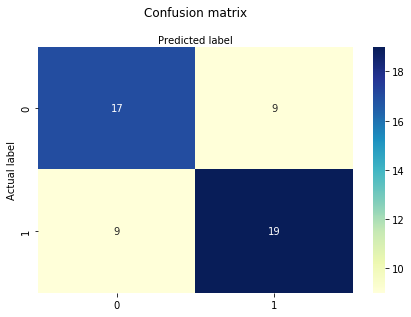

In [66]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')